<a href="https://colab.research.google.com/github/Shakib-IO/Human_AI_gsoc_2024/blob/main/TrOCR_Spanish_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 11.2 MB/s eta 0:00:00


###Dataset
The dataset consists of 31 pages of a scanned early modern printed text. The image has a simple recognition applied that reflects the limitations of the OCR already used (missed letters, incorrectly recognized words...), saved as a PDF file. The PDF is editable and can be saved as JPEGs if that helps with processing. Marginalia can be ignored, applicants should only focus on the main text, which is organized in two columns per page. The dataset also includes a transcription of 25 pages – they should be used as reference while training the AI models for the project. The transcription also includes a few notes that should help manage expectations of slight variability in spelling errors or limitations throughout the text. The last 6 pages of transcriptions have been removed to later evaluate the degree of accuracy and viability of the test method employed.


In [3]:
import pandas as pd
from PIL import Image
from datasets import load_metric
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel

In [4]:
df = pd.read_csv('/content/drive/MyDrive/spanish_dataset/sp_dataset.csv', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)

# some file names end with jp instead of jpg, let's fix this
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

,file_name,text
0,pg-01.jpg,DEDICATORIA EN LOS CONSEJOS que dexo a sus hij...
1,pg-02.jpg,tro Señor por sus rectisimos y ocul tos juyzio...
2,pg-03.jpg,de parte de Dios los doce mas ex celentes que ...
3,pg-04.jpg,"predeterminacion, a q se añaden en ca- da uno ..."
4,pg-05.jpg,ella es suficiente premio del virtuo- so: es t...


In [5]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [6]:
print("Train Data length:",len(train_df))
print("Test Data length:", len(test_df))

Train Data length: 17
Test Data length: 8


Each element of the dataset should return 2 things:

```
- pixel_values, which serve as input to the model.
- labels, which are the input_ids of the corresponding text in the image

```

In [8]:
class SP_Dataset(Dataset):
  def __init__(self, root_dir, df, processor, max_target_length = 384):
    self.root_dir = root_dir
    self.df = df
    self.processor = processor
    self.max_target_length = max_target_length

  def __len__(self):
      return len(self.df)

  def __getitem__(self, index):
    file_name = df['file_name'][index]
    text = df['text'][index]
    # Load the images
    image = Image.open(self.root_dir + file_name).convert("RGB")
    pixel_values = self.processor(image, return_tensors="pt").pixel_values
    # add labels (input_ids) by encoding the text
    labels = self.processor.tokenizer(text,
                                        padding="max_length",
                                        max_length=self.max_target_length).input_ids
    # important: make sure that PAD tokens are ignored by the loss function
    labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

    encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
    return encoding

In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = SP_Dataset(root_dir = '/content/drive/MyDrive/spanish_dataset/images/',
                              df = train_df,
                              processor = processor)
test_dataset = SP_Dataset(root_dir = '/content/drive/MyDrive/spanish_dataset/images/',
                             df = test_df,
                             processor = processor)


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 17
Number of test examples: 8


In [14]:
data = train_dataset[0]
for i, j in data.items():
  print(i, j.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([384])


In [31]:
train_df.head(20)

,file_name,text
0,pg-09.jpg,"versos: los locos, y los que mas lo son, enamo..."
1,pg-15.jpg,"Numa, Anibal, Socrates, Cesar, Sci- pion, Cato..."
2,pg-05.jpg,ella es suficiente premio del virtuo- so: es t...
3,pg-23.jpg,"Tiles lo conocieron assi, y los vene- raron po..."
4,pg-25.jpg,avia juzgado) tan indecente para es- perar tal...
5,pg-02.jpg,tro Señor por sus rectisimos y ocul tos juyzio...
6,pg-01.jpg,DEDICATORIA EN LOS CONSEJOS que dexo a sus hij...
7,pg-06.jpg,"fa de immortal, que a los mortales toque. Para..."
8,pg-14.jpg,y usad en todas vuestras acciones con sencille...
9,pg-21.jpg,gestad que alli preside. No seays de los inqui...


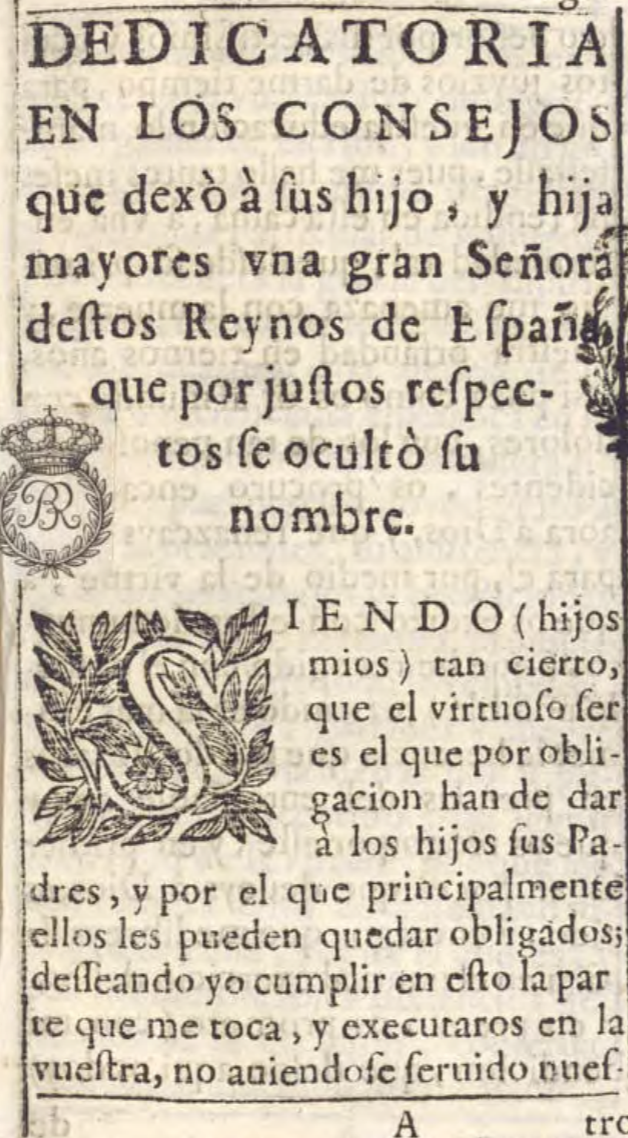

In [32]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][6]).convert("RGB")
image

In [33]:
labels = data['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

DEDICATORIA EN LOS CONSEJOS que dexo a sus hijo, e hija mayores una gran Señora destos Reynos de España que por justos respec- tos se ocultó su nombre. SIENDO (hijos mios) tan cierto, que el virtuoso ser es el que por obli- gacion han de dar a los hijos sus Pa- dres, y por el que principalmente ellos les pueden quedar obligados; desseando yo cumplir en esto la par te que me toca, y executaros en la vuestra, no aviendose servido nues


```We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa.```

In [34]:
# Load the model TrOCR(VisionEncoderDecoderModel)
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [35]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
from datasets import load_metric
cer_metric = load_metric("cer")

In [37]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [38]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
   model.eval()
   test_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(test_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"])
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       test_cer += cer

   print("Test CER:", test_cer / len(test_dataloader))

model.save_pretrained(".")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

Loss after epoch 0: 7.33494234085083


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Test CER: 0.9064156854122866


  0%|          | 0/9 [00:00<?, ?it/s]

Loss after epoch 1: 6.50879626803928


  0%|          | 0/4 [00:00<?, ?it/s]

Test CER: 0.9088483517554009


  0%|          | 0/9 [00:00<?, ?it/s]

Loss after epoch 2: 6.290792571173774


  0%|          | 0/4 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Test CER: 0.8966411190602572


### Inference

In [40]:
# Load the image
test_image = '/content/drive/MyDrive/spanish_dataset/test_data/pg-26.jpg'
image = Image.open(test_image).convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 384, 384])


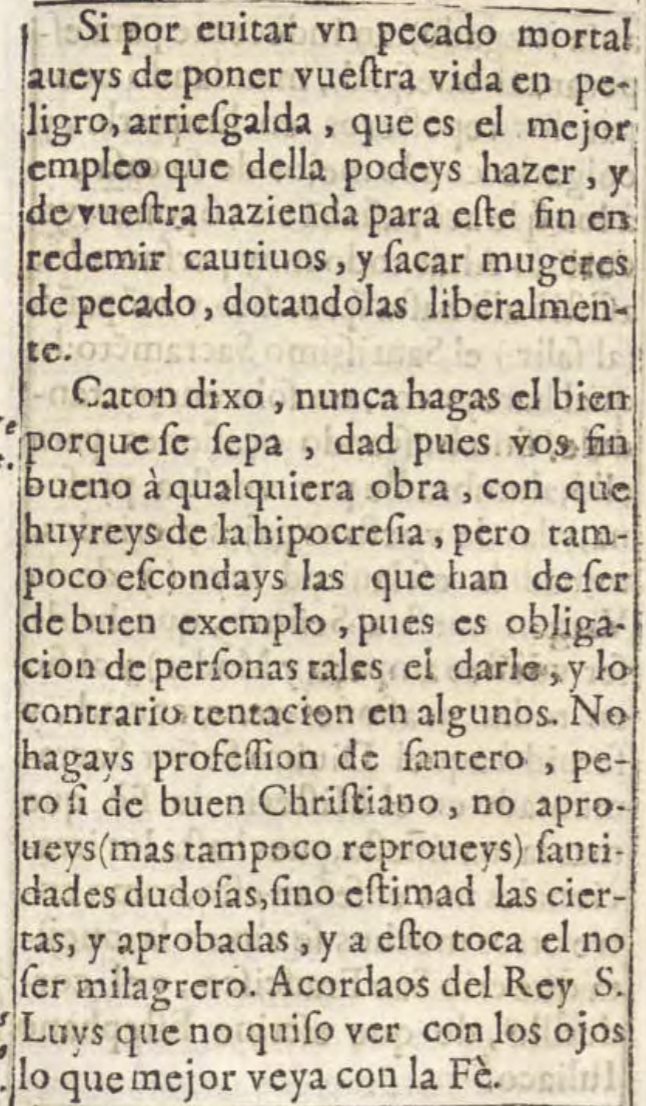

In [41]:
image

In [42]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

,,-,,,o,, y,, de,, que,, la,,a,, a,, con,, en,, por,, es,, p,, to,,e,, el,,i,, los,, v,,os,,


In [46]:
f = '/content/saved'

In [51]:
d = model.from_pretrained(f)

In [52]:
generated = d.generate(pixel_values)
generated_texts = processor.batch_decode(generated, skip_special_tokens=False)[0]
print(generated_texts)

<s>,,-,,,o,, y,, de,, que,, la,,a,, a,, con,, en,, por,, es,, p,, to,,e,, el,,i,, los,, v,,os,,
